In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

import matplotlib
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

%matplotlib inline

In [0]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [ ]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 100))
fixed_target = torch.randint(0,10,(50,)) # Makes fixed targets and fixed_z for test plots.

In [0]:
# One-hot transform for labels.
def one_hot_encode(x, dim=10):
    ohe = torch.zeros((x.shape[0], dim)).to(device)
    ohe.scatter_(-1, x.view(-1, 1), 1)
    return ohe

In [0]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn)
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [0]:
class Generator(nn.Module):    
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(Generator, self).__init__()
        self.fc = FullyConnected(sizes, dropout, activation_fn, flatten, last_fn)

    def forward(self, x, c):        
        x = torch.cat([x, one_hot_encode(c)], 1)
        return self.fc(x)

class Discriminator(nn.Module):    
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(Discriminator, self).__init__()
        self.fc = FullyConnected(sizes, dropout, activation_fn, flatten, last_fn)        

    def forward(self, x, c):
        x = x.view(-1, 28*28)
        x = torch.cat([x, one_hot_encode(c)], 1)
        y = self.fc(x)        
        return y

In [0]:
# Generator input size for prior and labels.
G = Generator([prior_size+10, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
# Discrminator input size for image and labels.
D = Discriminator([28*28+10, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)
G.to(device)
D.to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [0]:
train_log = {"G": [], "D": []}
test_log = {"G": [], "D": []}

In [0]:
# True / fake labels.
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [0]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        # train Discriminator.
        data = data.to(device)
        target = target.to(device)
        D.zero_grad()
        G.zero_grad()
        # Random z and labels input for Generator.
        z = torch.randn((batch_size, prior_size)).to(device)
        rand_target = torch.randint(10, (batch_size, )).to(device)
        # Discriminator output for generated and true data.
        fake_pred = D(G(z, rand_target), rand_target)
        true_pred = D(data, target)
        
        # Discriminator loss.
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)                
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train Generator
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size)).to(device)
        rand_target = torch.randint(10, (batch_size, )).to(device)
        fake_pred = D(G(z, rand_target), rand_target)
           
        # Generator loss to train it to make images that looks like true to discriminator.
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)        
        
        G_loss.backward()        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = "G: {:.4f}, D: {:.4f}".format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = "G: {:.4f}, D: {:.4f}".format(G_loss.item(), D_loss.item())
        print(line + losses)
        log["G"].append(G_loss.item())
        log["D"].append(D_loss.item())

In [0]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {"G": 0., "D": 0.}
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            z = torch.randn((batch_size, prior_size)).to(device)
            rand_target = torch.randint(10, (batch_size, )).to(device)
            fake_pred = D(G(z, rand_target), rand_target)
            true_pred = D(data, target)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    # Plot generated images from fixed z and labels.
    fixed_gen = G(fixed_z.to(device), fixed_target.to(device)).cpu().data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True)
    report = "Test losses. G: {:.4f}, D: {:.4f}".format(G_loss, D_loss)
    print(report)
    if log is not None:
        log["G"].append(G_loss)
        log["D"].append(D_loss)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 1.1877, D: 0.5958
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 1.1172, D: 0.5649
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 1.0708, D: 0.5968


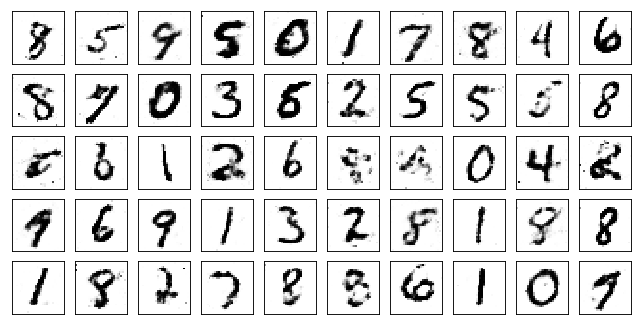

Test losses. G: 1.0498, D: 0.5868
Train Epoch: 2 [0/50000 (0%)]	Losses G: 1.1150, D: 0.6123
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 1.0527, D: 0.5938
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 0.9140, D: 0.6485


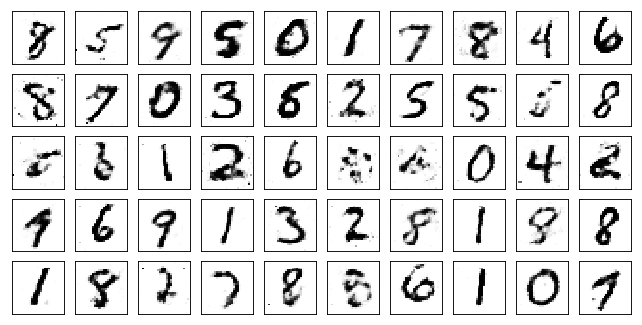

Test losses. G: 0.8954, D: 0.6000
Train Epoch: 3 [0/50000 (0%)]	Losses G: 1.0048, D: 0.6482
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 1.1820, D: 0.5338
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 1.0869, D: 0.5981


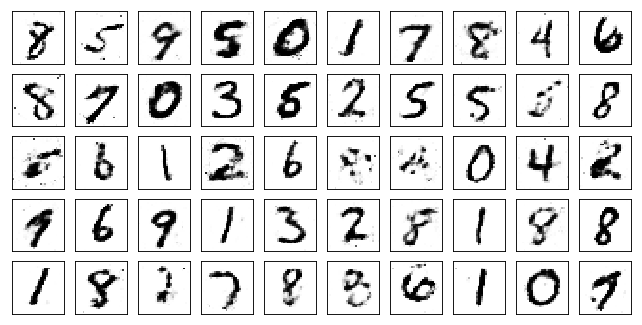

Test losses. G: 1.0800, D: 0.5517
Train Epoch: 4 [0/50000 (0%)]	Losses G: 1.0534, D: 0.5876
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 1.1063, D: 0.5817
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 1.0434, D: 0.6306


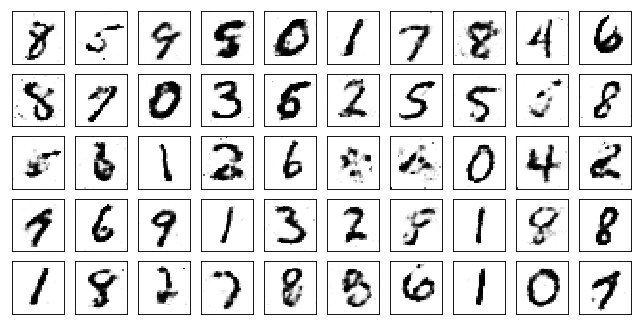

Test losses. G: 1.0674, D: 0.5752
Train Epoch: 5 [0/50000 (0%)]	Losses G: 0.9375, D: 0.6204
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 1.1803, D: 0.6061
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 0.8064, D: 0.6271


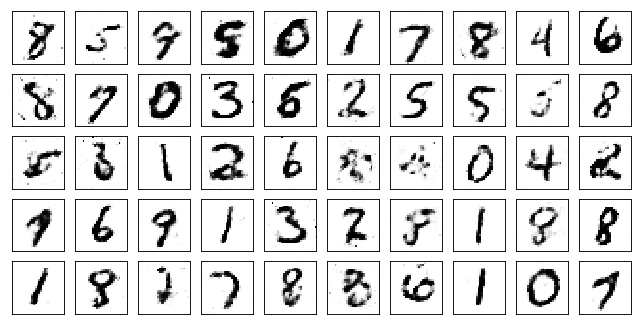

Test losses. G: 0.8608, D: 0.5897
Train Epoch: 6 [0/50000 (0%)]	Losses G: 0.8219, D: 0.5828
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 0.9865, D: 0.5895
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 1.0372, D: 0.5954


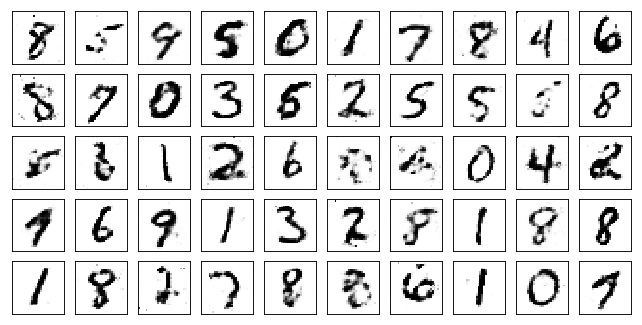

Test losses. G: 1.0783, D: 0.5583
Train Epoch: 7 [0/50000 (0%)]	Losses G: 1.0027, D: 0.5754
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 1.0450, D: 0.5754
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 1.0138, D: 0.6446


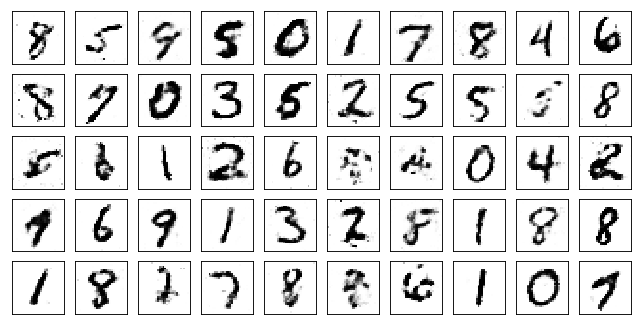

Test losses. G: 1.0425, D: 0.6053
Train Epoch: 8 [0/50000 (0%)]	Losses G: 1.0176, D: 0.6243
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 0.9509, D: 0.5887
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 1.0205, D: 0.5732


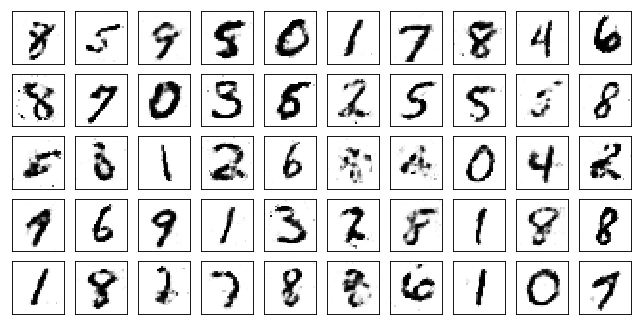

Test losses. G: 1.0978, D: 0.5488
Train Epoch: 9 [0/50000 (0%)]	Losses G: 1.0385, D: 0.5576
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 0.9148, D: 0.6174
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 0.9077, D: 0.6214


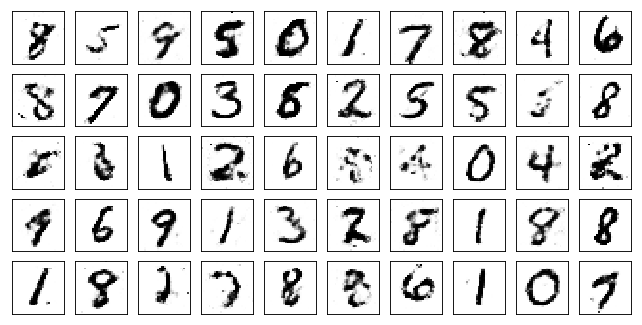

Test losses. G: 0.9203, D: 0.6067
Train Epoch: 10 [0/50000 (0%)]	Losses G: 0.8550, D: 0.6209
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 0.9111, D: 0.5769
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 1.2048, D: 0.5486


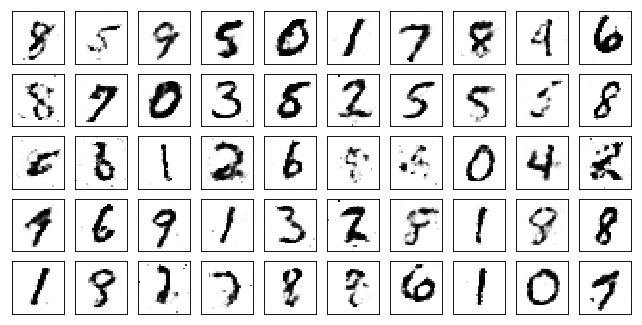

Test losses. G: 1.1743, D: 0.5308
Train Epoch: 11 [0/50000 (0%)]	Losses G: 1.1005, D: 0.5588
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 0.9589, D: 0.6042
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 0.9692, D: 0.6400


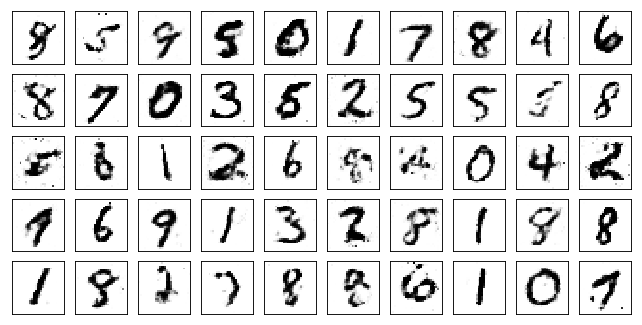

Test losses. G: 1.0039, D: 0.6154
Train Epoch: 12 [0/50000 (0%)]	Losses G: 0.9228, D: 0.6402
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 1.0426, D: 0.5750
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 1.2251, D: 0.5714


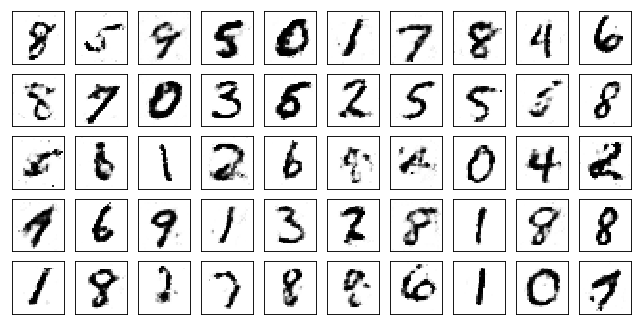

Test losses. G: 1.2038, D: 0.5348
Train Epoch: 13 [0/50000 (0%)]	Losses G: 1.2168, D: 0.5760
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 0.8874, D: 0.5924
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 0.9578, D: 0.5555


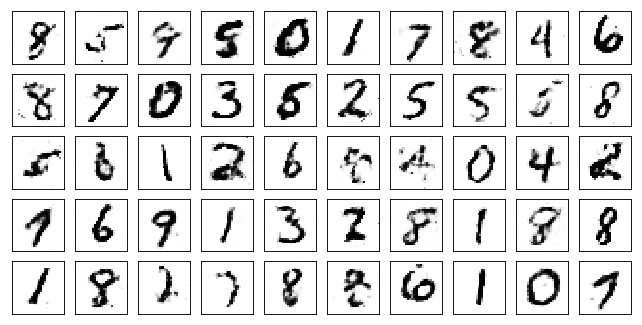

Test losses. G: 0.9161, D: 0.5994
Train Epoch: 14 [0/50000 (0%)]	Losses G: 0.9528, D: 0.6457
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 0.9109, D: 0.6115
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 0.9438, D: 0.5724


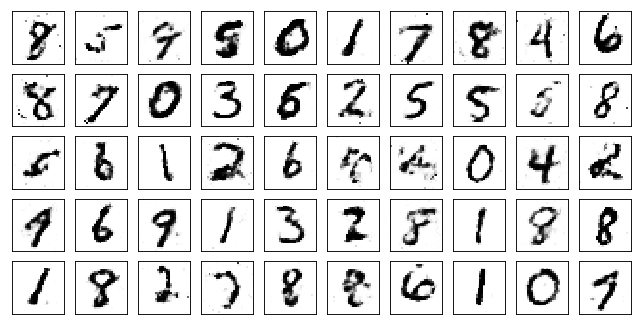

Test losses. G: 0.9502, D: 0.5667
Train Epoch: 15 [0/50000 (0%)]	Losses G: 0.9833, D: 0.5876
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 0.8834, D: 0.6626
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 0.9283, D: 0.6099


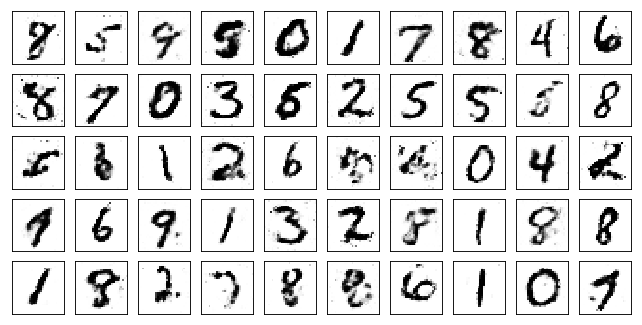

Test losses. G: 0.9956, D: 0.5810
Train Epoch: 16 [0/50000 (0%)]	Losses G: 1.0446, D: 0.6214
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 1.2036, D: 0.5892
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 0.9761, D: 0.6099


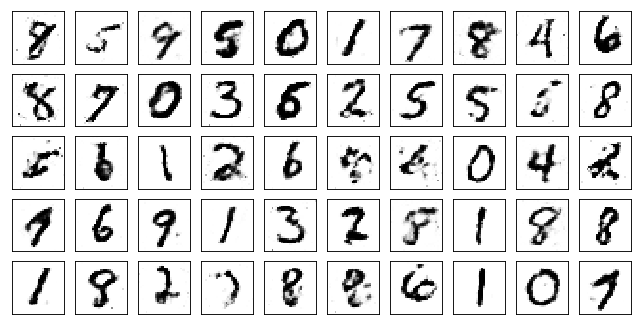

Test losses. G: 0.9670, D: 0.5916
Train Epoch: 17 [0/50000 (0%)]	Losses G: 0.9049, D: 0.6187
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 1.0197, D: 0.6192
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 1.1743, D: 0.5380


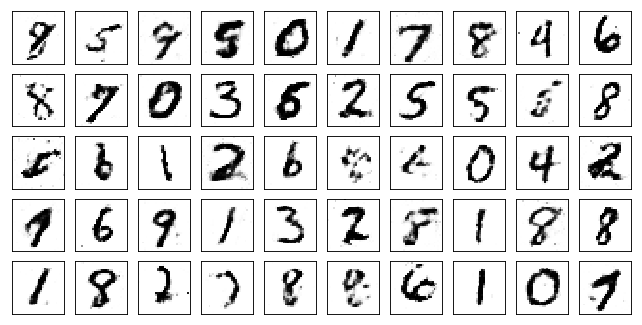

Test losses. G: 1.1363, D: 0.5153
Train Epoch: 18 [0/50000 (0%)]	Losses G: 1.1924, D: 0.5646
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 0.9706, D: 0.6308
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 0.9679, D: 0.6162


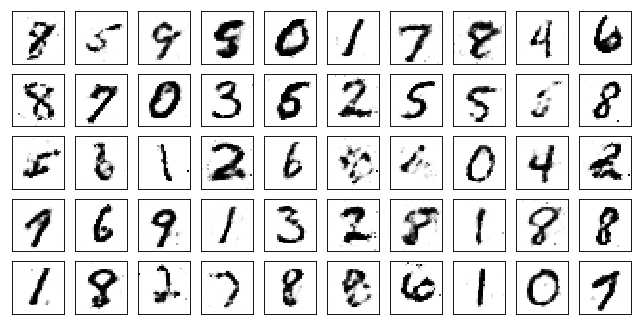

Test losses. G: 1.0330, D: 0.5963
Train Epoch: 19 [0/50000 (0%)]	Losses G: 0.9813, D: 0.5691
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 0.9646, D: 0.6198
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 0.9156, D: 0.6398


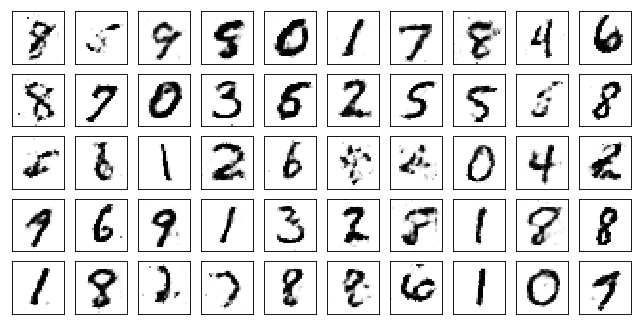

Test losses. G: 0.9103, D: 0.6018
Train Epoch: 20 [0/50000 (0%)]	Losses G: 0.8693, D: 0.6095
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 1.0295, D: 0.5704
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 1.4050, D: 0.5490


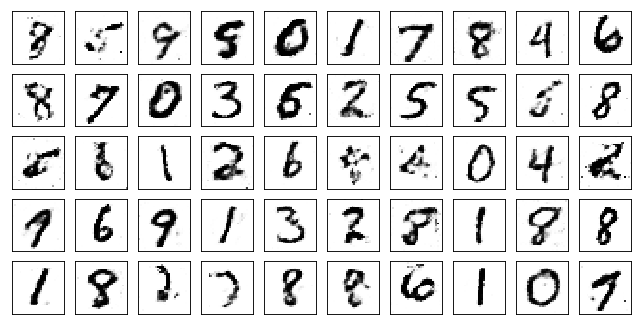

Test losses. G: 1.3645, D: 0.5366
Train Epoch: 21 [0/50000 (0%)]	Losses G: 1.3039, D: 0.5902
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 1.0536, D: 0.5806
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 0.9212, D: 0.5946


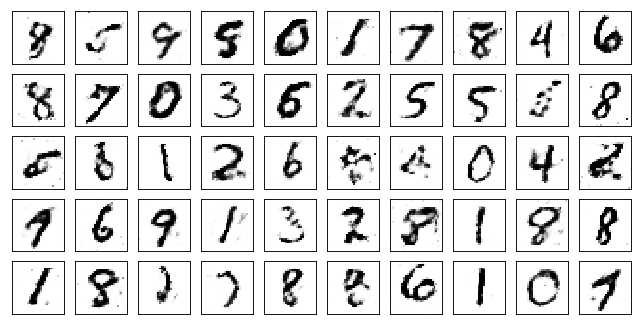

Test losses. G: 0.9520, D: 0.5750
Train Epoch: 22 [0/50000 (0%)]	Losses G: 0.9790, D: 0.6067
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 0.8923, D: 0.6266
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 0.8919, D: 0.6098


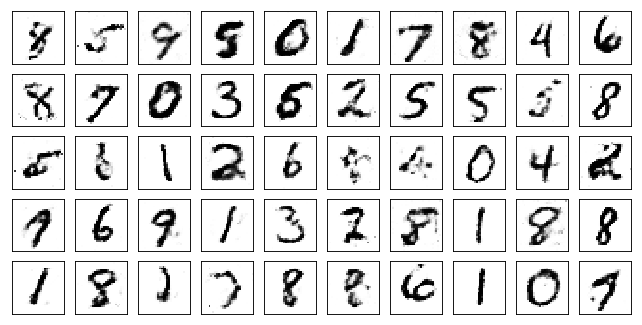

Test losses. G: 0.9107, D: 0.6007
Train Epoch: 23 [0/50000 (0%)]	Losses G: 0.8796, D: 0.6295
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 0.9876, D: 0.6054
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 1.1726, D: 0.5599


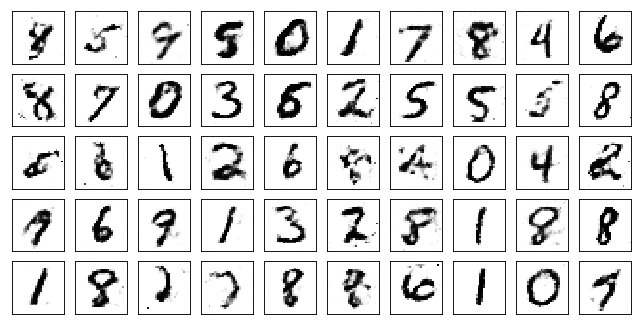

Test losses. G: 1.1556, D: 0.5265
Train Epoch: 24 [0/50000 (0%)]	Losses G: 1.1148, D: 0.5164
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 1.0948, D: 0.5594
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 1.0134, D: 0.6344


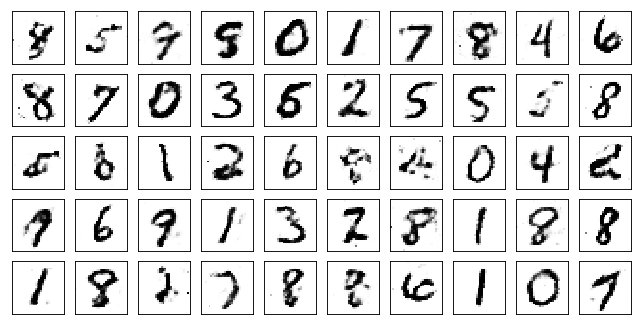

Test losses. G: 1.0668, D: 0.5936
Train Epoch: 25 [0/50000 (0%)]	Losses G: 0.9651, D: 0.6137
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 0.9944, D: 0.5886
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 1.2130, D: 0.6524


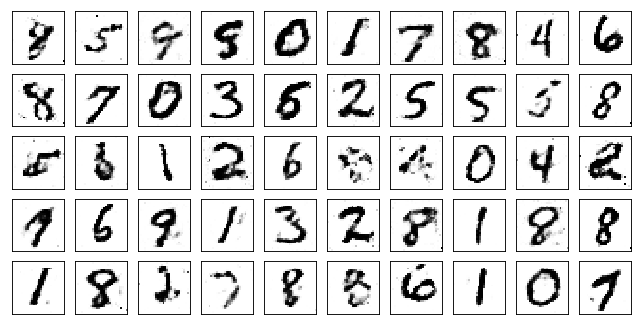

Test losses. G: 1.1613, D: 0.5831
Train Epoch: 26 [0/50000 (0%)]	Losses G: 1.1803, D: 0.6718
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 1.0958, D: 0.5868
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 1.1712, D: 0.5992


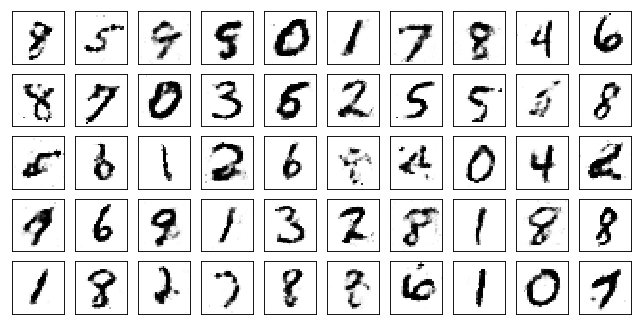

Test losses. G: 1.2005, D: 0.5216
Train Epoch: 27 [0/50000 (0%)]	Losses G: 1.2312, D: 0.5932
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 1.0002, D: 0.6225
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 0.9407, D: 0.6294


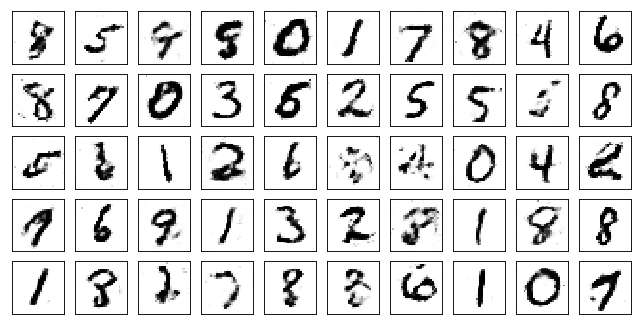

Test losses. G: 0.9402, D: 0.6113
Train Epoch: 28 [0/50000 (0%)]	Losses G: 0.9733, D: 0.6129
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 0.9774, D: 0.6169
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 1.0054, D: 0.5798


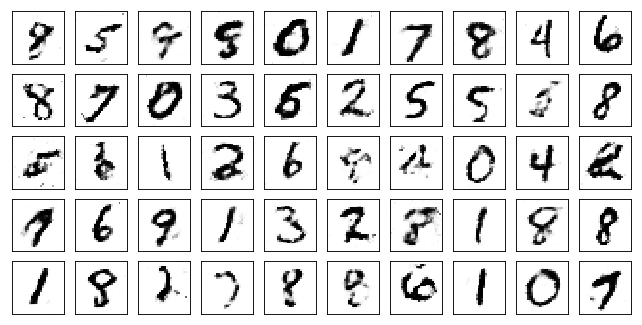

Test losses. G: 1.0054, D: 0.5730
Train Epoch: 29 [0/50000 (0%)]	Losses G: 1.0535, D: 0.5749
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 1.1182, D: 0.5667
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 0.9004, D: 0.6475


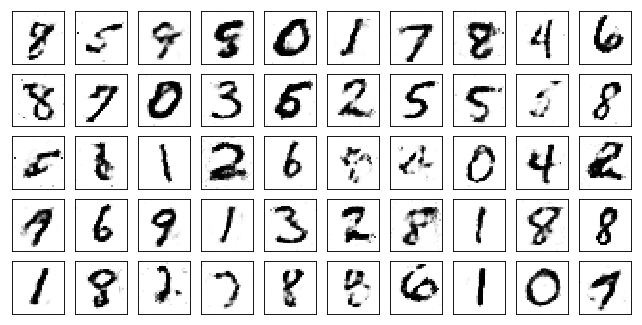

Test losses. G: 0.8697, D: 0.6095
Train Epoch: 30 [0/50000 (0%)]	Losses G: 0.9853, D: 0.6199
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 1.2162, D: 0.6166
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 1.0732, D: 0.6190


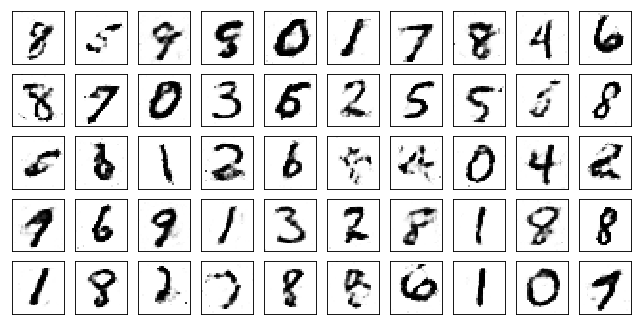

Test losses. G: 1.1222, D: 0.5792
Train Epoch: 31 [0/50000 (0%)]	Losses G: 1.0586, D: 0.5776
Train Epoch: 31 [25000/50000 (50%)]	Losses G: 0.9252, D: 0.6272
Train Epoch: 31 [50000/50000 (100%)]	Losses G: 0.9543, D: 0.5957


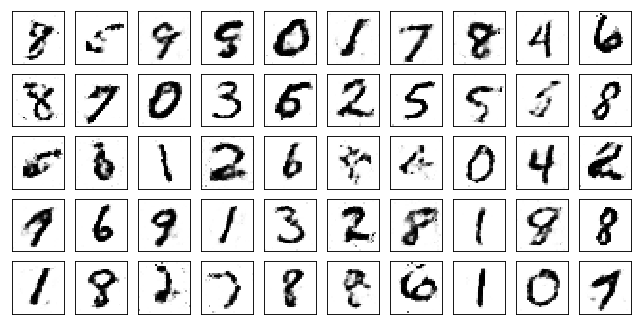

Test losses. G: 0.9986, D: 0.5531
Train Epoch: 32 [0/50000 (0%)]	Losses G: 0.9560, D: 0.5878
Train Epoch: 32 [25000/50000 (50%)]	Losses G: 1.1301, D: 0.5603
Train Epoch: 32 [50000/50000 (100%)]	Losses G: 0.9520, D: 0.5983


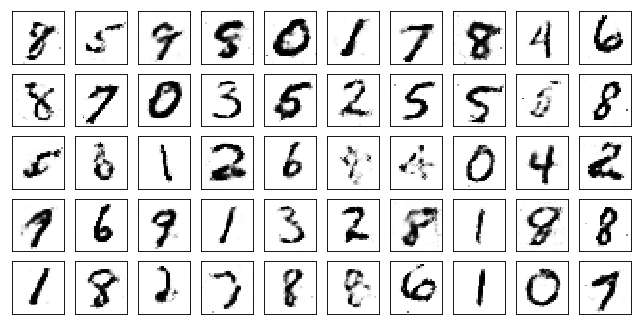

Test losses. G: 0.9849, D: 0.5963
Train Epoch: 33 [0/50000 (0%)]	Losses G: 0.9388, D: 0.5835
Train Epoch: 33 [25000/50000 (50%)]	Losses G: 0.9707, D: 0.6214
Train Epoch: 33 [50000/50000 (100%)]	Losses G: 0.9782, D: 0.6296


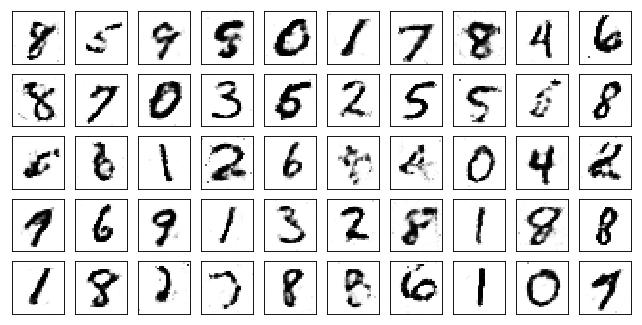

Test losses. G: 0.9090, D: 0.6181
Train Epoch: 34 [0/50000 (0%)]	Losses G: 0.8788, D: 0.6465
Train Epoch: 34 [25000/50000 (50%)]	Losses G: 0.9584, D: 0.5946
Train Epoch: 34 [50000/50000 (100%)]	Losses G: 0.9124, D: 0.5776


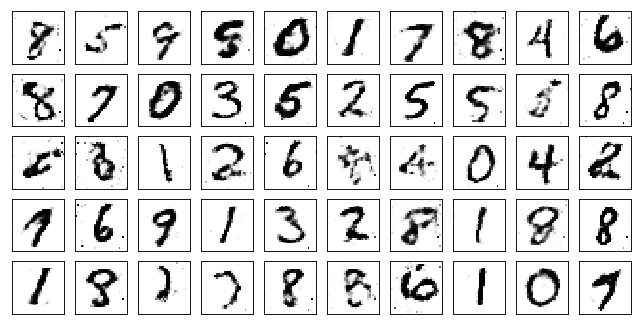

Test losses. G: 0.9505, D: 0.5934
Train Epoch: 35 [0/50000 (0%)]	Losses G: 0.9927, D: 0.5954
Train Epoch: 35 [25000/50000 (50%)]	Losses G: 1.0141, D: 0.5856
Train Epoch: 35 [50000/50000 (100%)]	Losses G: 0.8992, D: 0.6162


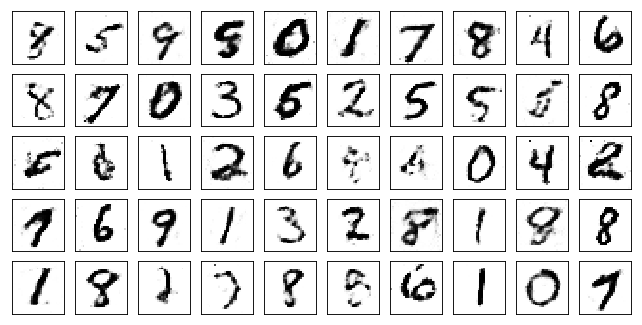

Test losses. G: 0.9560, D: 0.5937
Train Epoch: 36 [0/50000 (0%)]	Losses G: 0.9117, D: 0.6519
Train Epoch: 36 [25000/50000 (50%)]	Losses G: 1.0424, D: 0.5927
Train Epoch: 36 [50000/50000 (100%)]	Losses G: 1.1998, D: 0.5582


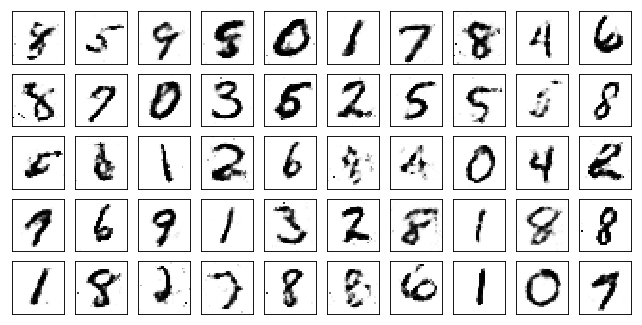

Test losses. G: 1.1585, D: 0.5429
Train Epoch: 37 [0/50000 (0%)]	Losses G: 1.1449, D: 0.5951
Train Epoch: 37 [25000/50000 (50%)]	Losses G: 1.1113, D: 0.5731
Train Epoch: 37 [50000/50000 (100%)]	Losses G: 0.9952, D: 0.6070


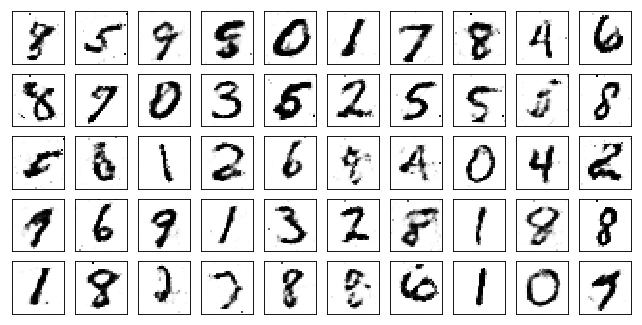

Test losses. G: 1.0267, D: 0.5685
Train Epoch: 38 [0/50000 (0%)]	Losses G: 0.9988, D: 0.6178
Train Epoch: 38 [25000/50000 (50%)]	Losses G: 1.1869, D: 0.6021
Train Epoch: 38 [50000/50000 (100%)]	Losses G: 1.0202, D: 0.5949


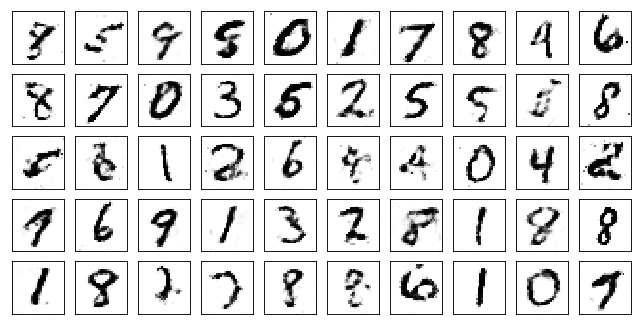

Test losses. G: 1.0312, D: 0.5807
Train Epoch: 39 [0/50000 (0%)]	Losses G: 0.9651, D: 0.5733
Train Epoch: 39 [25000/50000 (50%)]	Losses G: 1.1394, D: 0.5561
Train Epoch: 39 [50000/50000 (100%)]	Losses G: 1.2164, D: 0.6469


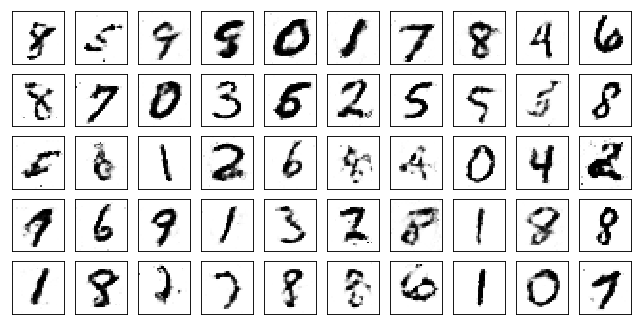

Test losses. G: 1.0805, D: 0.6091
Train Epoch: 40 [0/50000 (0%)]	Losses G: 1.0415, D: 0.6537
Train Epoch: 40 [25000/50000 (50%)]	Losses G: 1.0662, D: 0.5544
Train Epoch: 40 [50000/50000 (100%)]	Losses G: 1.1335, D: 0.5830


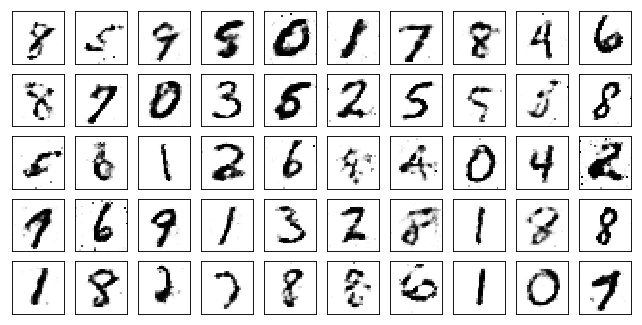

Test losses. G: 1.0647, D: 0.5508
Train Epoch: 41 [0/50000 (0%)]	Losses G: 1.1840, D: 0.6132
Train Epoch: 41 [25000/50000 (50%)]	Losses G: 1.0407, D: 0.5910
Train Epoch: 41 [50000/50000 (100%)]	Losses G: 0.9471, D: 0.6266


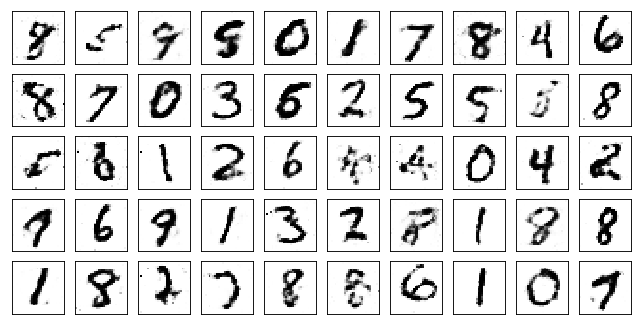

Test losses. G: 0.9043, D: 0.6033
Train Epoch: 42 [0/50000 (0%)]	Losses G: 0.9567, D: 0.6511
Train Epoch: 42 [25000/50000 (50%)]	Losses G: 0.8004, D: 0.6271
Train Epoch: 42 [50000/50000 (100%)]	Losses G: 0.8275, D: 0.6234


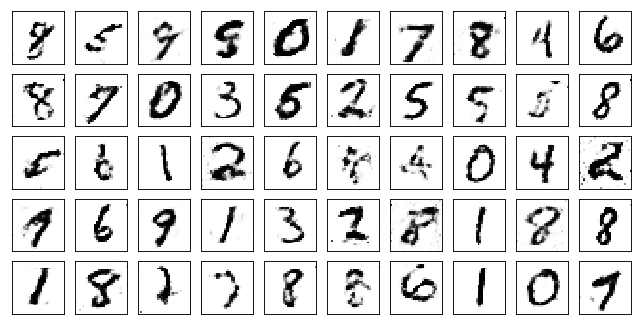

Test losses. G: 0.8849, D: 0.6065
Train Epoch: 43 [0/50000 (0%)]	Losses G: 0.8965, D: 0.6336
Train Epoch: 43 [25000/50000 (50%)]	Losses G: 1.0178, D: 0.6042
Train Epoch: 43 [50000/50000 (100%)]	Losses G: 1.1523, D: 0.5905


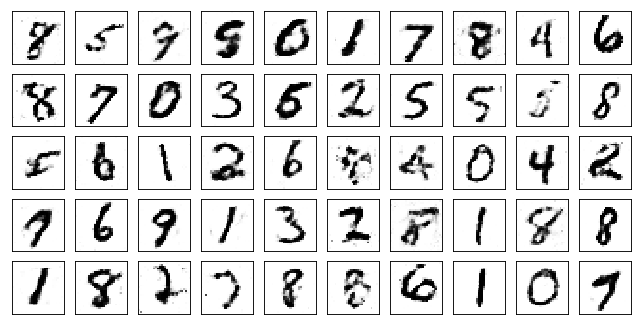

Test losses. G: 1.0783, D: 0.5731
Train Epoch: 44 [0/50000 (0%)]	Losses G: 0.9627, D: 0.6247
Train Epoch: 44 [25000/50000 (50%)]	Losses G: 0.9036, D: 0.6328
Train Epoch: 44 [50000/50000 (100%)]	Losses G: 0.9447, D: 0.6173


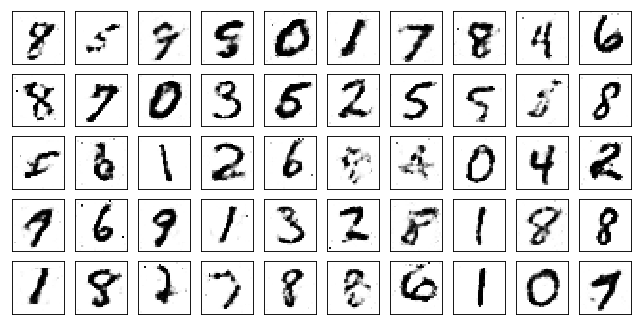

Test losses. G: 0.9581, D: 0.5976
Train Epoch: 45 [0/50000 (0%)]	Losses G: 0.9658, D: 0.6173
Train Epoch: 45 [25000/50000 (50%)]	Losses G: 1.1257, D: 0.5608
Train Epoch: 45 [50000/50000 (100%)]	Losses G: 1.1138, D: 0.5786


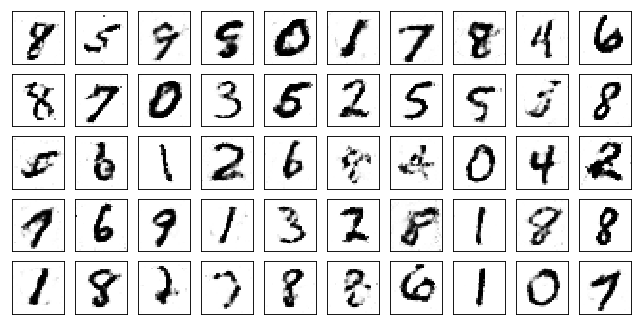

Test losses. G: 1.0754, D: 0.5319
Train Epoch: 46 [0/50000 (0%)]	Losses G: 1.0635, D: 0.5657
Train Epoch: 46 [25000/50000 (50%)]	Losses G: 1.0044, D: 0.6458
Train Epoch: 46 [50000/50000 (100%)]	Losses G: 0.9903, D: 0.6004


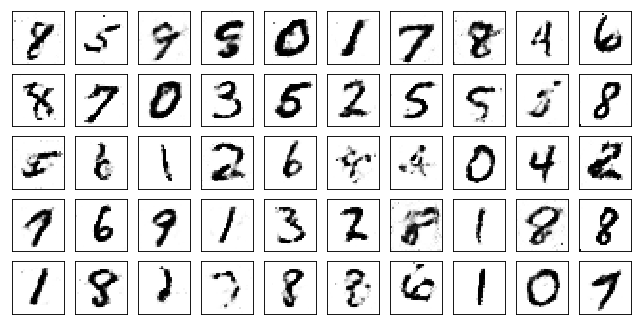

Test losses. G: 1.0031, D: 0.5844
Train Epoch: 47 [0/50000 (0%)]	Losses G: 1.0465, D: 0.6174
Train Epoch: 47 [25000/50000 (50%)]	Losses G: 0.8644, D: 0.6249
Train Epoch: 47 [50000/50000 (100%)]	Losses G: 0.8964, D: 0.6036


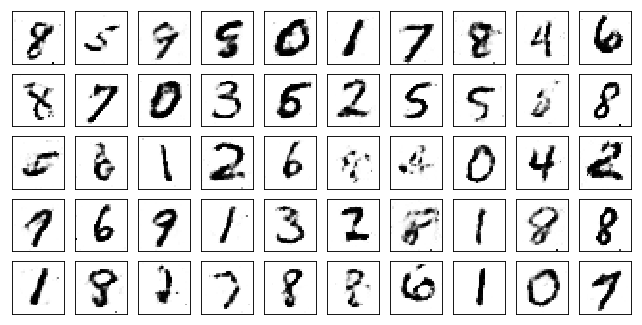

Test losses. G: 0.9192, D: 0.5913
Train Epoch: 48 [0/50000 (0%)]	Losses G: 0.9310, D: 0.6071
Train Epoch: 48 [25000/50000 (50%)]	Losses G: 0.8507, D: 0.5750
Train Epoch: 48 [50000/50000 (100%)]	Losses G: 0.8548, D: 0.6196


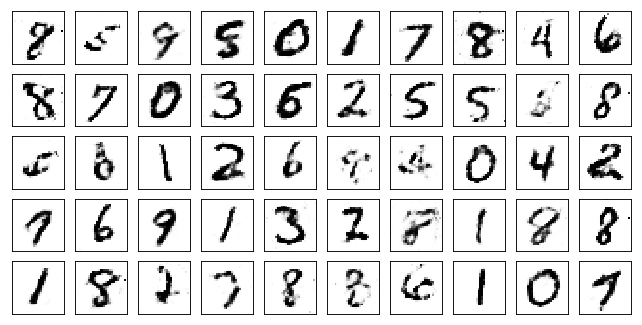

Test losses. G: 0.8721, D: 0.6154
Train Epoch: 49 [0/50000 (0%)]	Losses G: 0.8603, D: 0.6139
Train Epoch: 49 [25000/50000 (50%)]	Losses G: 0.9956, D: 0.6140
Train Epoch: 49 [50000/50000 (100%)]	Losses G: 0.8855, D: 0.6042


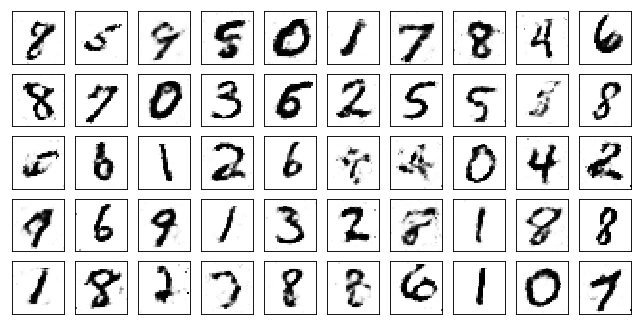

Test losses. G: 0.9138, D: 0.6117
Train Epoch: 50 [0/50000 (0%)]	Losses G: 0.9030, D: 0.6221
Train Epoch: 50 [25000/50000 (50%)]	Losses G: 1.0059, D: 0.6048
Train Epoch: 50 [50000/50000 (100%)]	Losses G: 0.9850, D: 0.6006


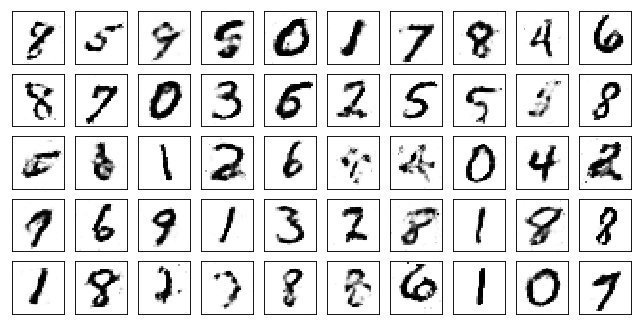

Test losses. G: 1.0513, D: 0.6049
Train Epoch: 51 [0/50000 (0%)]	Losses G: 1.0243, D: 0.6089
Train Epoch: 51 [25000/50000 (50%)]	Losses G: 0.8688, D: 0.6133
Train Epoch: 51 [50000/50000 (100%)]	Losses G: 1.0033, D: 0.5708


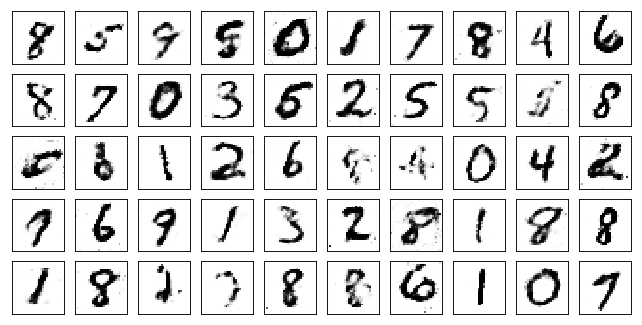

Test losses. G: 1.0177, D: 0.5809
Train Epoch: 52 [0/50000 (0%)]	Losses G: 0.9739, D: 0.5944
Train Epoch: 52 [25000/50000 (50%)]	Losses G: 0.9145, D: 0.6594
Train Epoch: 52 [50000/50000 (100%)]	Losses G: 0.9287, D: 0.6211


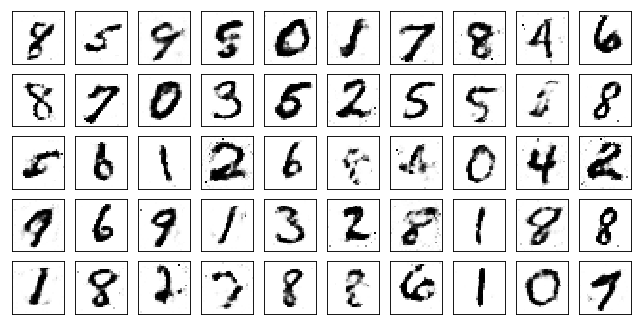

Test losses. G: 0.9378, D: 0.6186
Train Epoch: 53 [0/50000 (0%)]	Losses G: 0.9028, D: 0.6352
Train Epoch: 53 [25000/50000 (50%)]	Losses G: 0.9367, D: 0.6145
Train Epoch: 53 [50000/50000 (100%)]	Losses G: 0.9397, D: 0.6159


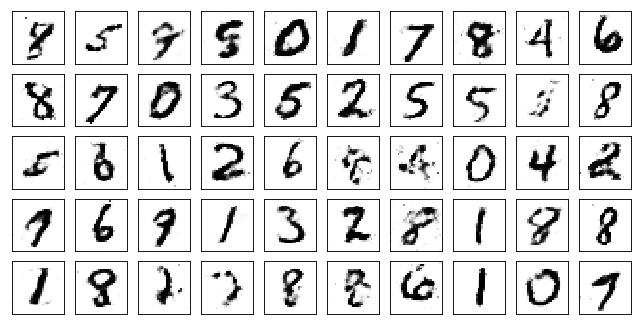

Test losses. G: 0.9399, D: 0.6239
Train Epoch: 54 [0/50000 (0%)]	Losses G: 0.8923, D: 0.6269
Train Epoch: 54 [25000/50000 (50%)]	Losses G: 1.0778, D: 0.6062
Train Epoch: 54 [50000/50000 (100%)]	Losses G: 0.9336, D: 0.6190


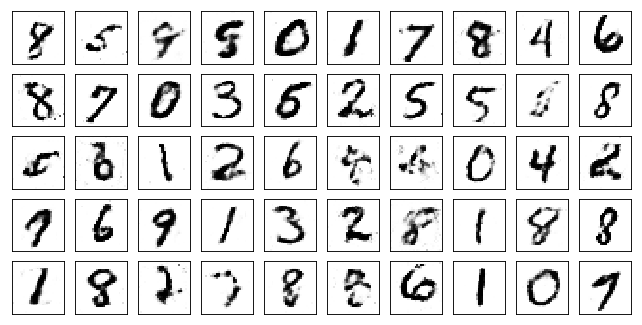

Test losses. G: 0.8808, D: 0.6247
Train Epoch: 55 [0/50000 (0%)]	Losses G: 0.8865, D: 0.5935
Train Epoch: 55 [25000/50000 (50%)]	Losses G: 0.8258, D: 0.6562
Train Epoch: 55 [50000/50000 (100%)]	Losses G: 0.9697, D: 0.6540


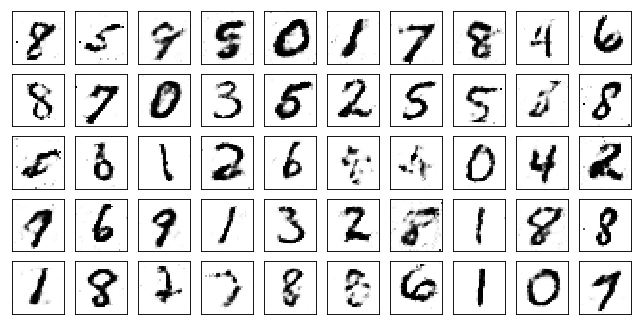

Test losses. G: 0.9810, D: 0.6130
Train Epoch: 56 [0/50000 (0%)]	Losses G: 0.9934, D: 0.6885
Train Epoch: 56 [25000/50000 (50%)]	Losses G: 0.9421, D: 0.6040
Train Epoch: 56 [50000/50000 (100%)]	Losses G: 1.0047, D: 0.6492


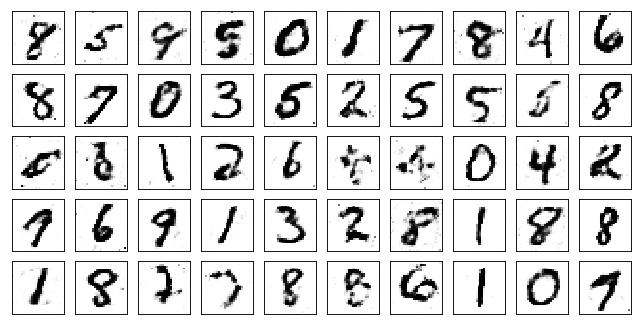

Test losses. G: 0.9866, D: 0.6144
Train Epoch: 57 [0/50000 (0%)]	Losses G: 0.9553, D: 0.6328
Train Epoch: 57 [25000/50000 (50%)]	Losses G: 0.9104, D: 0.6263
Train Epoch: 57 [50000/50000 (100%)]	Losses G: 1.2210, D: 0.5640


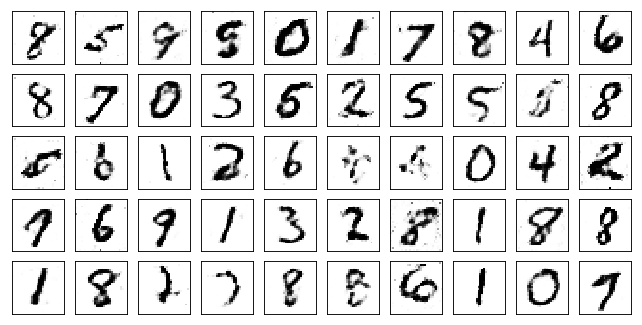

Test losses. G: 1.1168, D: 0.5404
Train Epoch: 58 [0/50000 (0%)]	Losses G: 1.1851, D: 0.5775
Train Epoch: 58 [25000/50000 (50%)]	Losses G: 1.1710, D: 0.5247
Train Epoch: 58 [50000/50000 (100%)]	Losses G: 0.9818, D: 0.5936


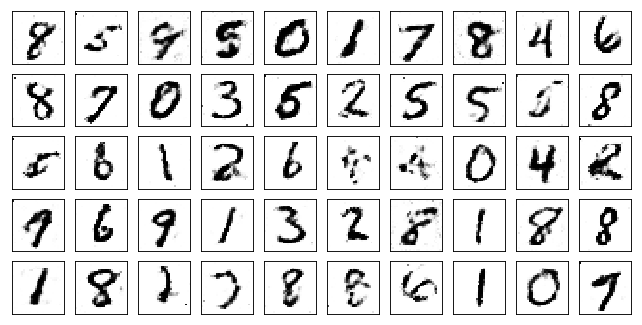

Test losses. G: 0.9568, D: 0.5827
Train Epoch: 59 [0/50000 (0%)]	Losses G: 1.0490, D: 0.6062
Train Epoch: 59 [25000/50000 (50%)]	Losses G: 0.8118, D: 0.6268
Train Epoch: 59 [50000/50000 (100%)]	Losses G: 0.9259, D: 0.6392


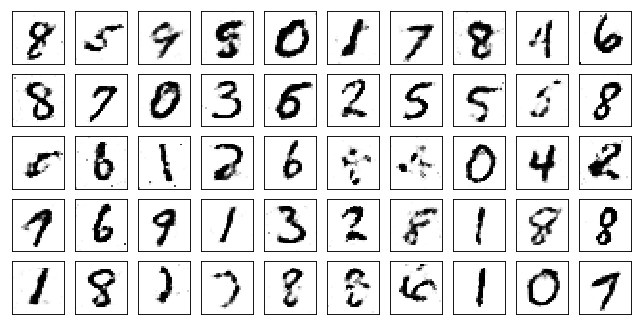

Test losses. G: 0.9082, D: 0.6147
Train Epoch: 60 [0/50000 (0%)]	Losses G: 0.9300, D: 0.6157
Train Epoch: 60 [25000/50000 (50%)]	Losses G: 0.8839, D: 0.6429
Train Epoch: 60 [50000/50000 (100%)]	Losses G: 0.8824, D: 0.6590


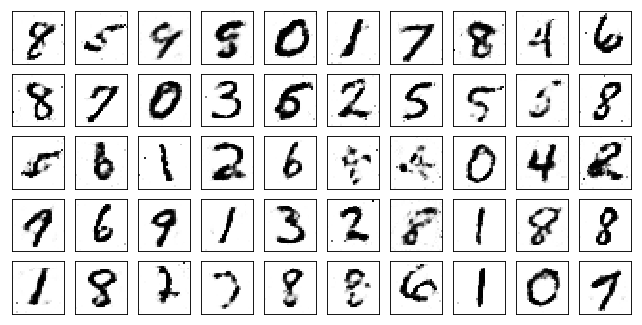

Test losses. G: 0.8923, D: 0.6116
Train Epoch: 61 [0/50000 (0%)]	Losses G: 0.9342, D: 0.6297
Train Epoch: 61 [25000/50000 (50%)]	Losses G: 1.1958, D: 0.5451
Train Epoch: 61 [50000/50000 (100%)]	Losses G: 1.1318, D: 0.5959


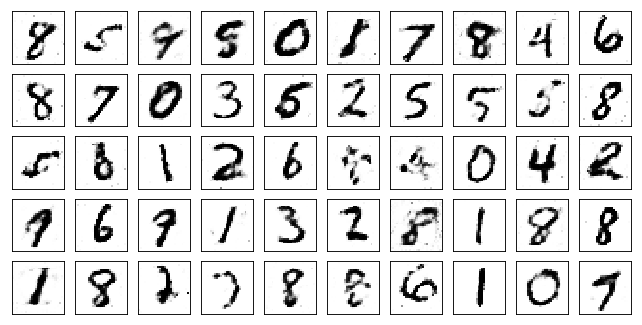

Test losses. G: 1.0749, D: 0.5411
Train Epoch: 62 [0/50000 (0%)]	Losses G: 1.2455, D: 0.5887
Train Epoch: 62 [25000/50000 (50%)]	Losses G: 1.1577, D: 0.5284
Train Epoch: 62 [50000/50000 (100%)]	Losses G: 1.1797, D: 0.6083


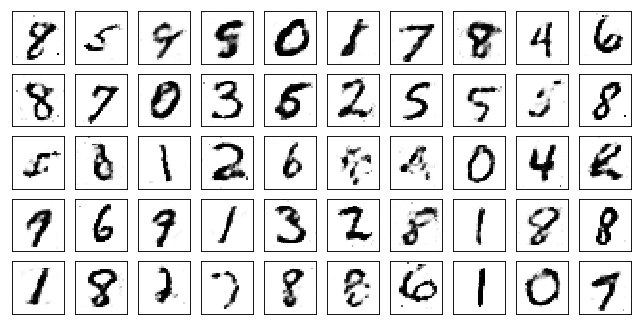

Test losses. G: 1.0980, D: 0.5784
Train Epoch: 63 [0/50000 (0%)]	Losses G: 1.0511, D: 0.5867
Train Epoch: 63 [25000/50000 (50%)]	Losses G: 0.9834, D: 0.5967
Train Epoch: 63 [50000/50000 (100%)]	Losses G: 0.9440, D: 0.6637


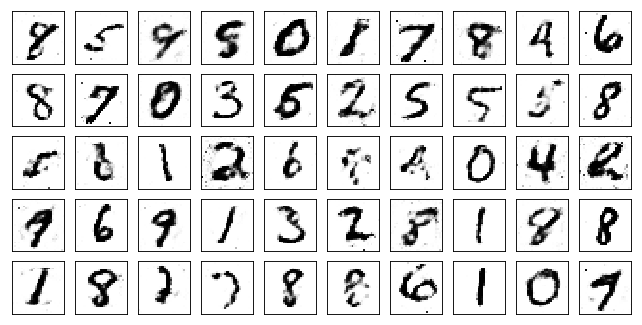

Test losses. G: 0.8686, D: 0.6174
Train Epoch: 64 [0/50000 (0%)]	Losses G: 0.8798, D: 0.6399
Train Epoch: 64 [25000/50000 (50%)]	Losses G: 0.8926, D: 0.6577
Train Epoch: 64 [50000/50000 (100%)]	Losses G: 0.9193, D: 0.6519


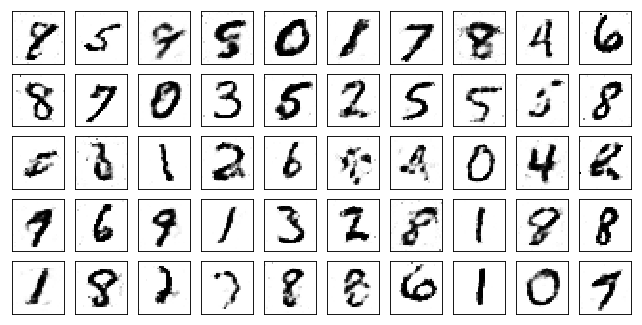

Test losses. G: 0.8878, D: 0.6362
Train Epoch: 65 [0/50000 (0%)]	Losses G: 0.9023, D: 0.6376
Train Epoch: 65 [25000/50000 (50%)]	Losses G: 0.9639, D: 0.6307
Train Epoch: 65 [50000/50000 (100%)]	Losses G: 0.8663, D: 0.6223


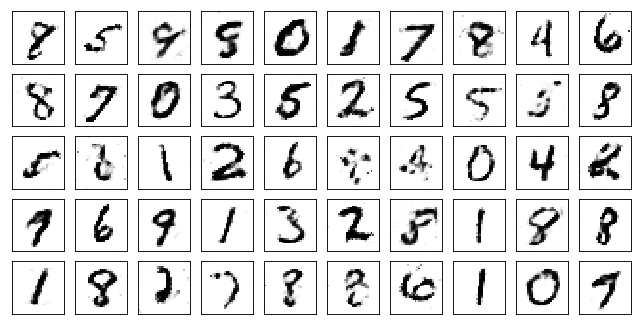

Test losses. G: 0.8632, D: 0.6091
Train Epoch: 66 [0/50000 (0%)]	Losses G: 0.8766, D: 0.6638
Train Epoch: 66 [25000/50000 (50%)]	Losses G: 0.8712, D: 0.6487
Train Epoch: 66 [50000/50000 (100%)]	Losses G: 0.9628, D: 0.5865


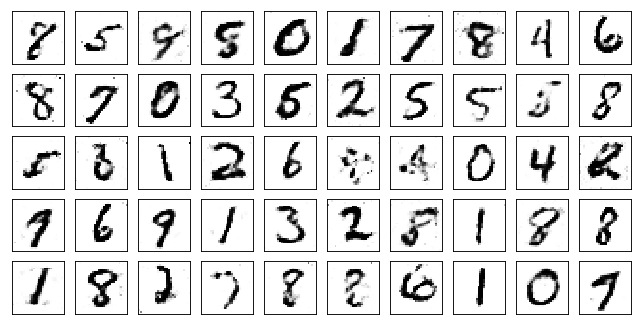

Test losses. G: 0.9624, D: 0.5929
Train Epoch: 67 [0/50000 (0%)]	Losses G: 1.0102, D: 0.6493
Train Epoch: 67 [25000/50000 (50%)]	Losses G: 0.9880, D: 0.5875
Train Epoch: 67 [50000/50000 (100%)]	Losses G: 1.1052, D: 0.5828


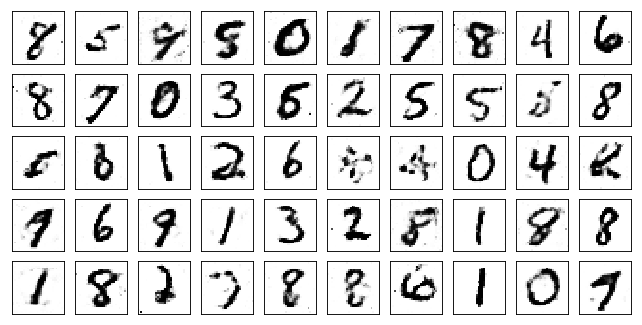

Test losses. G: 1.0893, D: 0.5555
Train Epoch: 68 [0/50000 (0%)]	Losses G: 1.1978, D: 0.5830
Train Epoch: 68 [25000/50000 (50%)]	Losses G: 0.8689, D: 0.6099
Train Epoch: 68 [50000/50000 (100%)]	Losses G: 1.0838, D: 0.6109


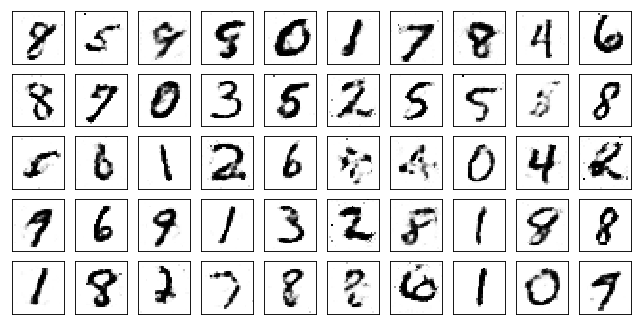

Test losses. G: 1.0536, D: 0.5759
Train Epoch: 69 [0/50000 (0%)]	Losses G: 1.0490, D: 0.5986
Train Epoch: 69 [25000/50000 (50%)]	Losses G: 0.9544, D: 0.6375
Train Epoch: 69 [50000/50000 (100%)]	Losses G: 0.8109, D: 0.6588


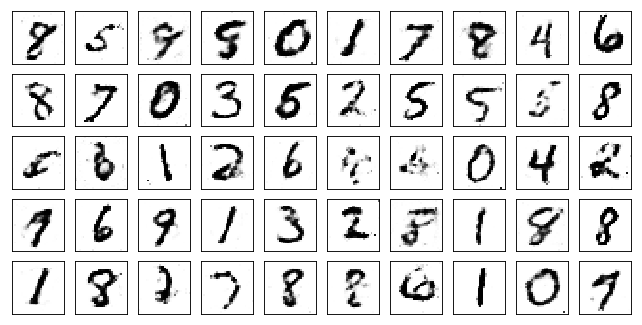

Test losses. G: 0.8216, D: 0.6328
Train Epoch: 70 [0/50000 (0%)]	Losses G: 0.8251, D: 0.6492
Train Epoch: 70 [25000/50000 (50%)]	Losses G: 0.9398, D: 0.6028
Train Epoch: 70 [50000/50000 (100%)]	Losses G: 1.0548, D: 0.6368


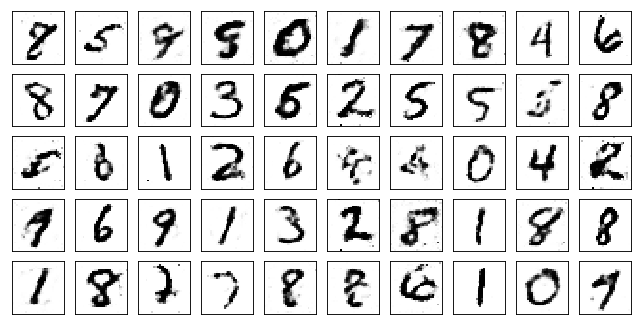

Test losses. G: 1.0284, D: 0.5856
Train Epoch: 71 [0/50000 (0%)]	Losses G: 1.0406, D: 0.6099
Train Epoch: 71 [25000/50000 (50%)]	Losses G: 1.1580, D: 0.5693
Train Epoch: 71 [50000/50000 (100%)]	Losses G: 1.1279, D: 0.5749


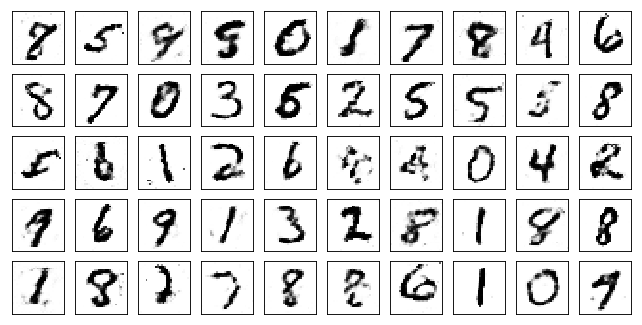

Test losses. G: 1.0816, D: 0.5336
Train Epoch: 72 [0/50000 (0%)]	Losses G: 1.1883, D: 0.5727
Train Epoch: 72 [25000/50000 (50%)]	Losses G: 1.0648, D: 0.5802
Train Epoch: 72 [50000/50000 (100%)]	Losses G: 0.8820, D: 0.6100


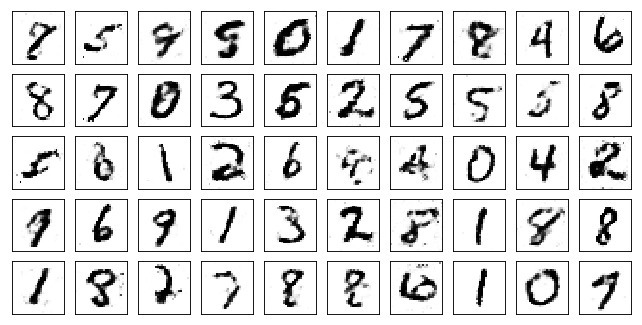

Test losses. G: 0.8703, D: 0.6259
Train Epoch: 73 [0/50000 (0%)]	Losses G: 0.8634, D: 0.6265
Train Epoch: 73 [25000/50000 (50%)]	Losses G: 1.0550, D: 0.6460
Train Epoch: 73 [50000/50000 (100%)]	Losses G: 1.1555, D: 0.5521


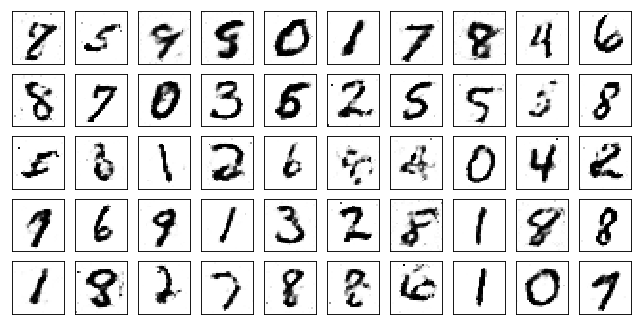

Test losses. G: 1.1008, D: 0.5933
Train Epoch: 74 [0/50000 (0%)]	Losses G: 1.0724, D: 0.6440
Train Epoch: 74 [25000/50000 (50%)]	Losses G: 1.1709, D: 0.5862
Train Epoch: 74 [50000/50000 (100%)]	Losses G: 1.0065, D: 0.5837


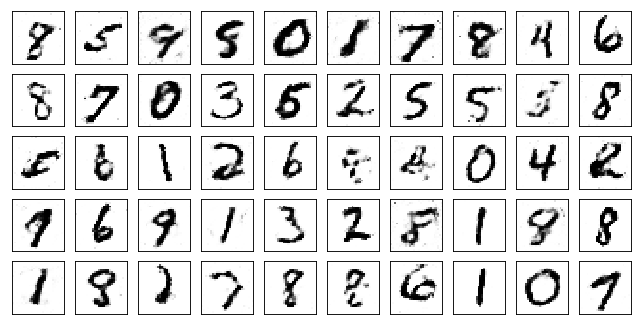

Test losses. G: 1.0254, D: 0.5721
Train Epoch: 75 [0/50000 (0%)]	Losses G: 0.9278, D: 0.5810
Train Epoch: 75 [25000/50000 (50%)]	Losses G: 0.9981, D: 0.5990
Train Epoch: 75 [50000/50000 (100%)]	Losses G: 0.9176, D: 0.6074


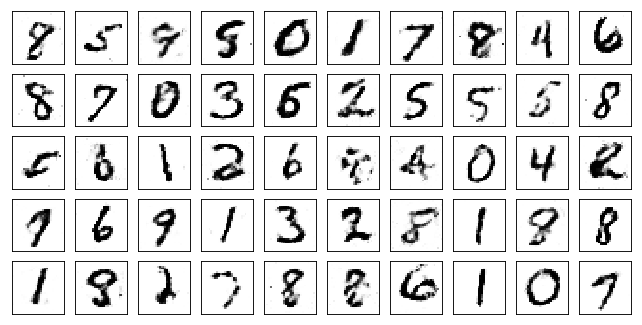

Test losses. G: 0.9445, D: 0.5671
Train Epoch: 76 [0/50000 (0%)]	Losses G: 1.0260, D: 0.6055
Train Epoch: 76 [25000/50000 (50%)]	Losses G: 1.1459, D: 0.5669
Train Epoch: 76 [50000/50000 (100%)]	Losses G: 1.0213, D: 0.5863


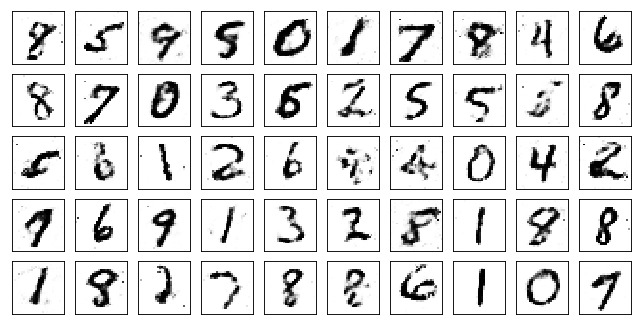

Test losses. G: 1.0011, D: 0.5814
Train Epoch: 77 [0/50000 (0%)]	Losses G: 0.9723, D: 0.5946
Train Epoch: 77 [25000/50000 (50%)]	Losses G: 0.9389, D: 0.6366
Train Epoch: 77 [50000/50000 (100%)]	Losses G: 1.0198, D: 0.6090


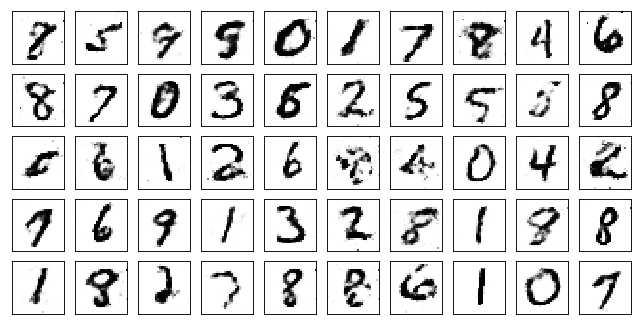

Test losses. G: 0.9673, D: 0.6107
Train Epoch: 78 [0/50000 (0%)]	Losses G: 0.8959, D: 0.6285
Train Epoch: 78 [25000/50000 (50%)]	Losses G: 0.9491, D: 0.6571
Train Epoch: 78 [50000/50000 (100%)]	Losses G: 0.9648, D: 0.6498


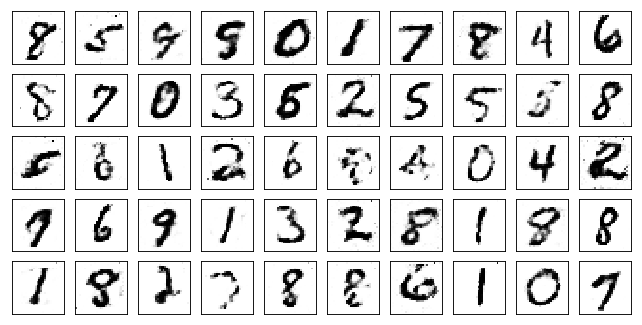

Test losses. G: 0.9439, D: 0.6241
Train Epoch: 79 [0/50000 (0%)]	Losses G: 0.8996, D: 0.6316
Train Epoch: 79 [25000/50000 (50%)]	Losses G: 0.9462, D: 0.6016
Train Epoch: 79 [50000/50000 (100%)]	Losses G: 0.9973, D: 0.5712


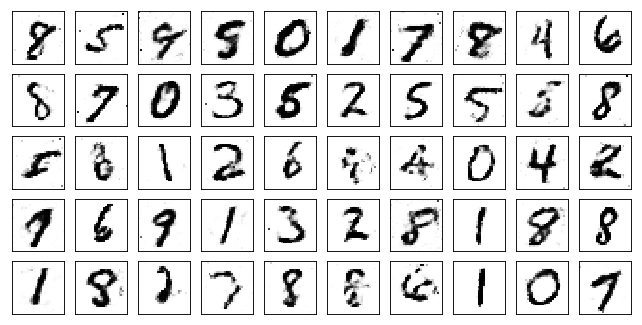

Test losses. G: 1.0367, D: 0.5851
Train Epoch: 80 [0/50000 (0%)]	Losses G: 0.9824, D: 0.5740
Train Epoch: 80 [25000/50000 (50%)]	Losses G: 0.9331, D: 0.6473
Train Epoch: 80 [50000/50000 (100%)]	Losses G: 0.7644, D: 0.6845


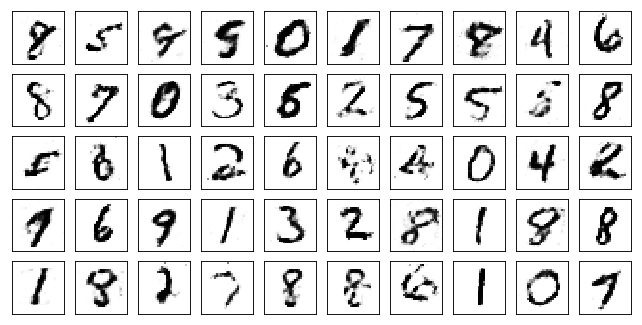

Test losses. G: 0.7691, D: 0.6507
Train Epoch: 81 [0/50000 (0%)]	Losses G: 0.7759, D: 0.6705
Train Epoch: 81 [25000/50000 (50%)]	Losses G: 1.0113, D: 0.6012
Train Epoch: 81 [50000/50000 (100%)]	Losses G: 0.9287, D: 0.6094


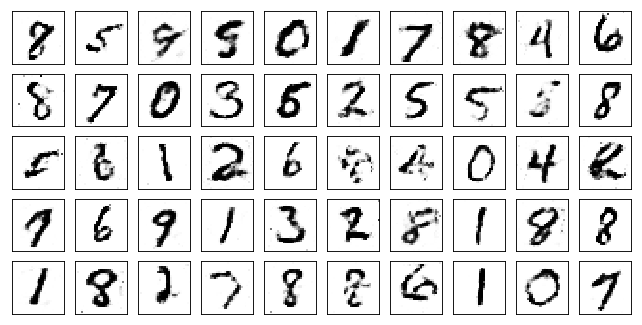

Test losses. G: 0.9384, D: 0.5927
Train Epoch: 82 [0/50000 (0%)]	Losses G: 0.9532, D: 0.5859
Train Epoch: 82 [25000/50000 (50%)]	Losses G: 0.9848, D: 0.5972
Train Epoch: 82 [50000/50000 (100%)]	Losses G: 1.1141, D: 0.5725


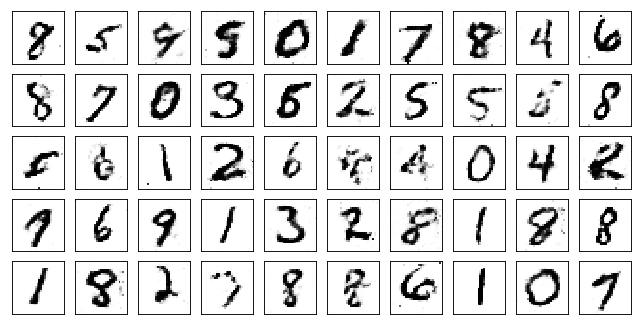

Test losses. G: 1.1047, D: 0.5637
Train Epoch: 83 [0/50000 (0%)]	Losses G: 1.1513, D: 0.6054
Train Epoch: 83 [25000/50000 (50%)]	Losses G: 0.8580, D: 0.6584
Train Epoch: 83 [50000/50000 (100%)]	Losses G: 0.8871, D: 0.6262


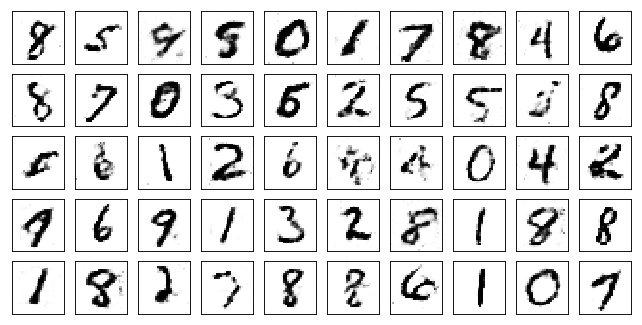

Test losses. G: 0.8624, D: 0.6247
Train Epoch: 84 [0/50000 (0%)]	Losses G: 0.8486, D: 0.6332
Train Epoch: 84 [25000/50000 (50%)]	Losses G: 0.9300, D: 0.6787
Train Epoch: 84 [50000/50000 (100%)]	Losses G: 1.0952, D: 0.6362


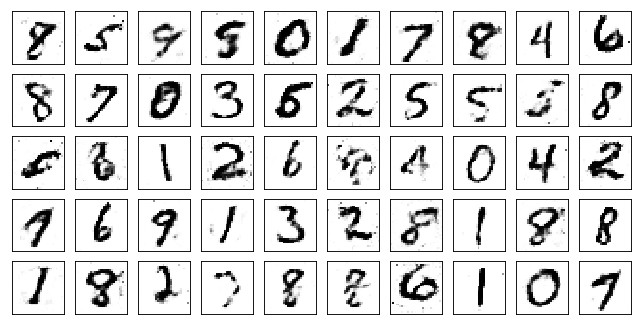

Test losses. G: 1.0066, D: 0.6118
Train Epoch: 85 [0/50000 (0%)]	Losses G: 0.9566, D: 0.6563
Train Epoch: 85 [25000/50000 (50%)]	Losses G: 0.8473, D: 0.6414
Train Epoch: 85 [50000/50000 (100%)]	Losses G: 1.0648, D: 0.6139


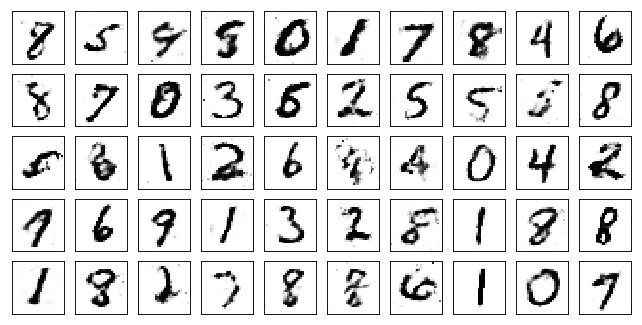

Test losses. G: 1.0627, D: 0.5652
Train Epoch: 86 [0/50000 (0%)]	Losses G: 1.0177, D: 0.5770
Train Epoch: 86 [25000/50000 (50%)]	Losses G: 0.8570, D: 0.5876
Train Epoch: 86 [50000/50000 (100%)]	Losses G: 1.0530, D: 0.5905


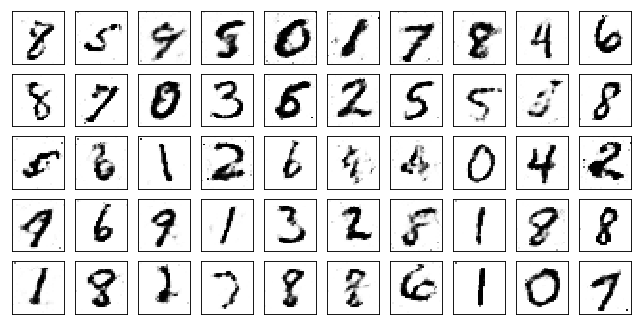

Test losses. G: 1.0174, D: 0.5887
Train Epoch: 87 [0/50000 (0%)]	Losses G: 1.0486, D: 0.6205
Train Epoch: 87 [25000/50000 (50%)]	Losses G: 1.0127, D: 0.5640
Train Epoch: 87 [50000/50000 (100%)]	Losses G: 0.8430, D: 0.6454


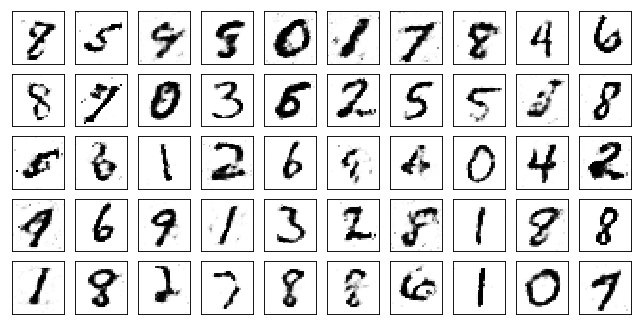

Test losses. G: 0.8955, D: 0.6292
Train Epoch: 88 [0/50000 (0%)]	Losses G: 0.8771, D: 0.6261
Train Epoch: 88 [25000/50000 (50%)]	Losses G: 0.8409, D: 0.6449
Train Epoch: 88 [50000/50000 (100%)]	Losses G: 0.9470, D: 0.6090


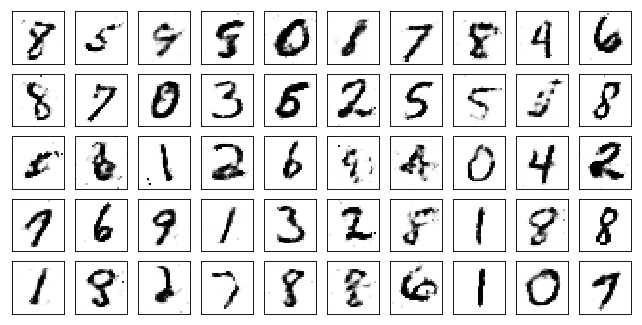

Test losses. G: 0.9345, D: 0.5951
Train Epoch: 89 [0/50000 (0%)]	Losses G: 0.9639, D: 0.5953
Train Epoch: 89 [25000/50000 (50%)]	Losses G: 1.0061, D: 0.5895
Train Epoch: 89 [50000/50000 (100%)]	Losses G: 1.0665, D: 0.5880


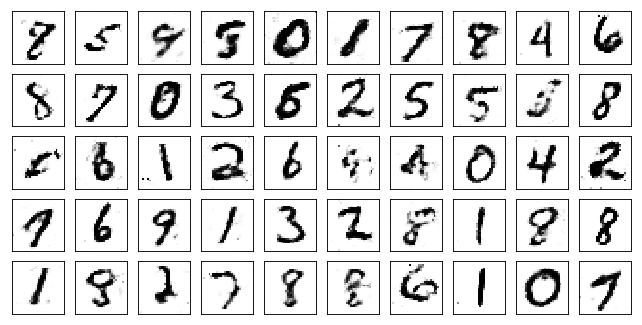

Test losses. G: 1.1200, D: 0.5609
Train Epoch: 90 [0/50000 (0%)]	Losses G: 1.0944, D: 0.5767
Train Epoch: 90 [25000/50000 (50%)]	Losses G: 0.8963, D: 0.6110
Train Epoch: 90 [50000/50000 (100%)]	Losses G: 0.8886, D: 0.6749


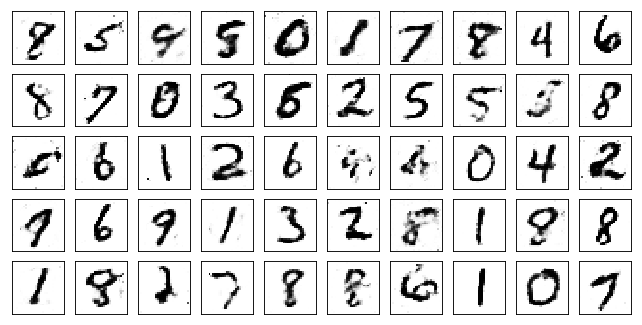

Test losses. G: 0.8777, D: 0.6281
Train Epoch: 91 [0/50000 (0%)]	Losses G: 0.9206, D: 0.6526
Train Epoch: 91 [25000/50000 (50%)]	Losses G: 0.8539, D: 0.6144
Train Epoch: 91 [50000/50000 (100%)]	Losses G: 0.9509, D: 0.5870


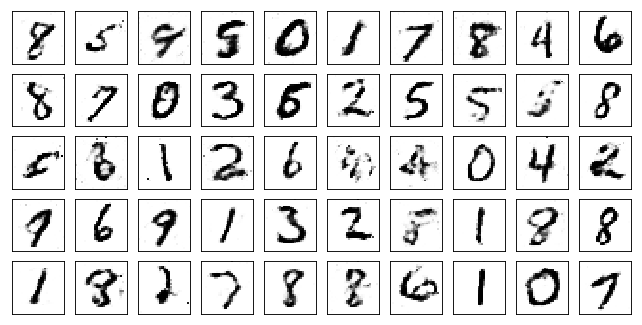

Test losses. G: 0.8717, D: 0.6018
Train Epoch: 92 [0/50000 (0%)]	Losses G: 0.8943, D: 0.6229
Train Epoch: 92 [25000/50000 (50%)]	Losses G: 0.8722, D: 0.6494
Train Epoch: 92 [50000/50000 (100%)]	Losses G: 1.0315, D: 0.6037


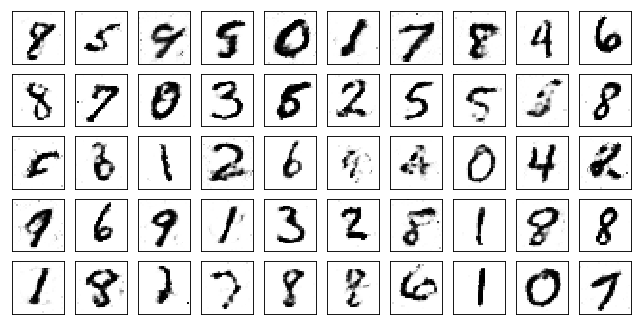

Test losses. G: 0.9898, D: 0.5836
Train Epoch: 93 [0/50000 (0%)]	Losses G: 0.9236, D: 0.6076
Train Epoch: 93 [25000/50000 (50%)]	Losses G: 0.9850, D: 0.5657
Train Epoch: 93 [50000/50000 (100%)]	Losses G: 0.8752, D: 0.6176


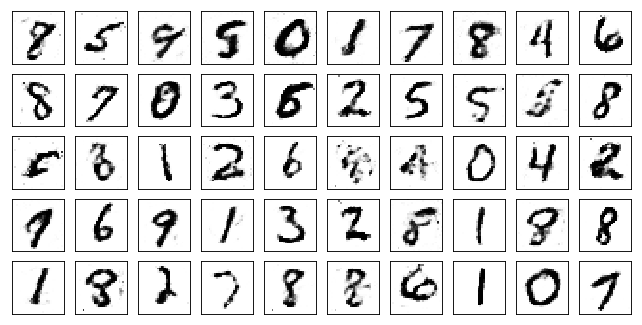

Test losses. G: 0.9063, D: 0.6031
Train Epoch: 94 [0/50000 (0%)]	Losses G: 0.9104, D: 0.6181
Train Epoch: 94 [25000/50000 (50%)]	Losses G: 0.8291, D: 0.6511
Train Epoch: 94 [50000/50000 (100%)]	Losses G: 0.9302, D: 0.5993


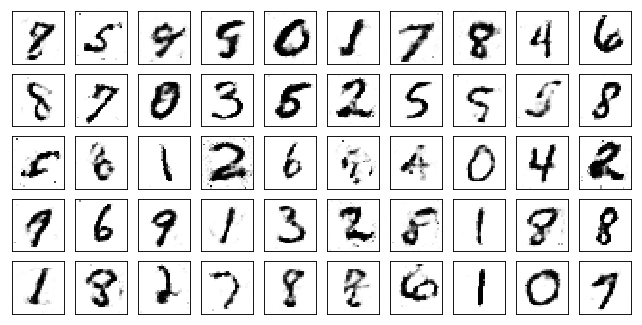

Test losses. G: 0.9585, D: 0.6115
Train Epoch: 95 [0/50000 (0%)]	Losses G: 0.9277, D: 0.6131
Train Epoch: 95 [25000/50000 (50%)]	Losses G: 0.8277, D: 0.6771
Train Epoch: 95 [50000/50000 (100%)]	Losses G: 0.8915, D: 0.6313


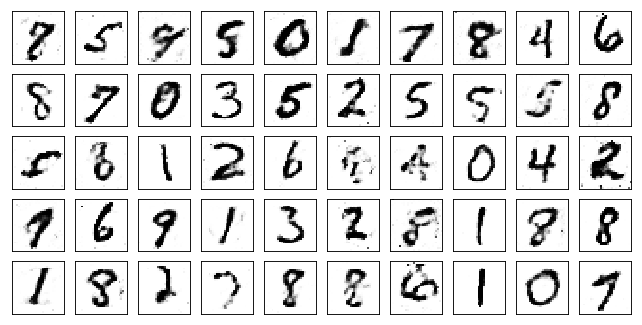

Test losses. G: 0.8833, D: 0.6390
Train Epoch: 96 [0/50000 (0%)]	Losses G: 0.8809, D: 0.6469
Train Epoch: 96 [25000/50000 (50%)]	Losses G: 0.9126, D: 0.6555
Train Epoch: 96 [50000/50000 (100%)]	Losses G: 0.9653, D: 0.6188


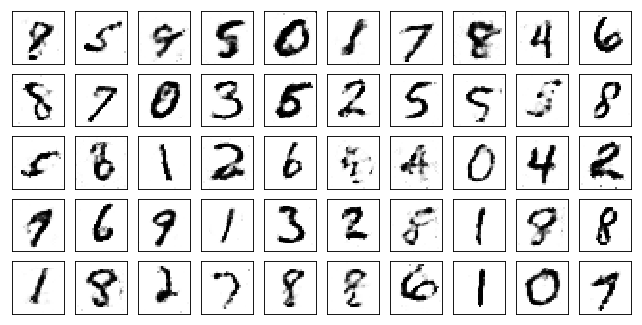

Test losses. G: 0.9885, D: 0.6072
Train Epoch: 97 [0/50000 (0%)]	Losses G: 0.9326, D: 0.6408
Train Epoch: 97 [25000/50000 (50%)]	Losses G: 1.0478, D: 0.6343
Train Epoch: 97 [50000/50000 (100%)]	Losses G: 0.9276, D: 0.5916


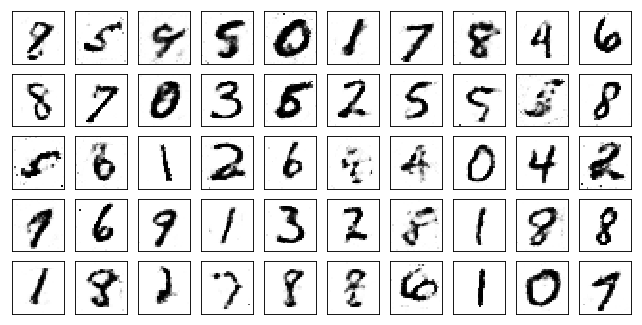

Test losses. G: 0.9368, D: 0.5808
Train Epoch: 98 [0/50000 (0%)]	Losses G: 0.9393, D: 0.6060
Train Epoch: 98 [25000/50000 (50%)]	Losses G: 1.0462, D: 0.6099
Train Epoch: 98 [50000/50000 (100%)]	Losses G: 0.9766, D: 0.5774


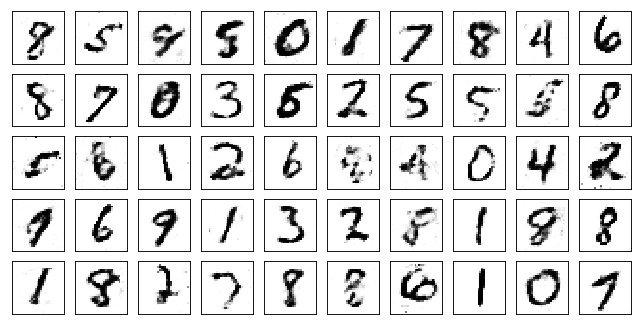

Test losses. G: 1.0478, D: 0.5794
Train Epoch: 99 [0/50000 (0%)]	Losses G: 1.0009, D: 0.5917
Train Epoch: 99 [25000/50000 (50%)]	Losses G: 0.9479, D: 0.5729
Train Epoch: 99 [50000/50000 (100%)]	Losses G: 1.1138, D: 0.5809


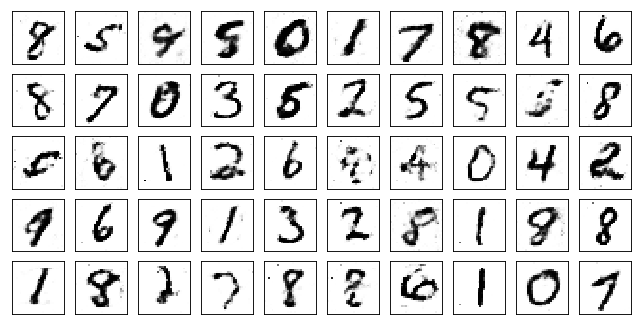

Test losses. G: 1.1554, D: 0.5768
Train Epoch: 100 [0/50000 (0%)]	Losses G: 1.1300, D: 0.5933
Train Epoch: 100 [25000/50000 (50%)]	Losses G: 1.0052, D: 0.5866
Train Epoch: 100 [50000/50000 (100%)]	Losses G: 1.0061, D: 0.5727


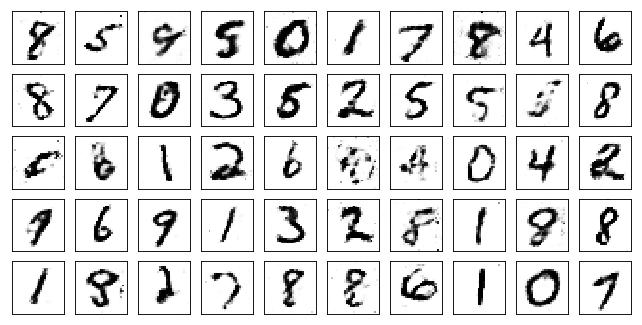

Test losses. G: 0.9927, D: 0.5755


In [40]:
for epoch in range(1, 101):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)

In [38]:
fixed_target.view(5, -1)

tensor([[8, 5, 9, 5, 0, 1, 7, 8, 4, 6],
        [8, 7, 0, 3, 5, 2, 5, 5, 5, 8],
        [5, 6, 1, 2, 6, 8, 4, 0, 4, 2],
        [9, 6, 9, 1, 3, 2, 8, 1, 8, 8],
        [1, 8, 2, 7, 8, 8, 6, 1, 0, 7]])

After 300 training epochs, numbers on generated images are quite distinguidhable and match the fixed labels. The loss plots show that discriminator learns to differ true from fake images fast, but with more training generator is doing better job at decieving discriminator.

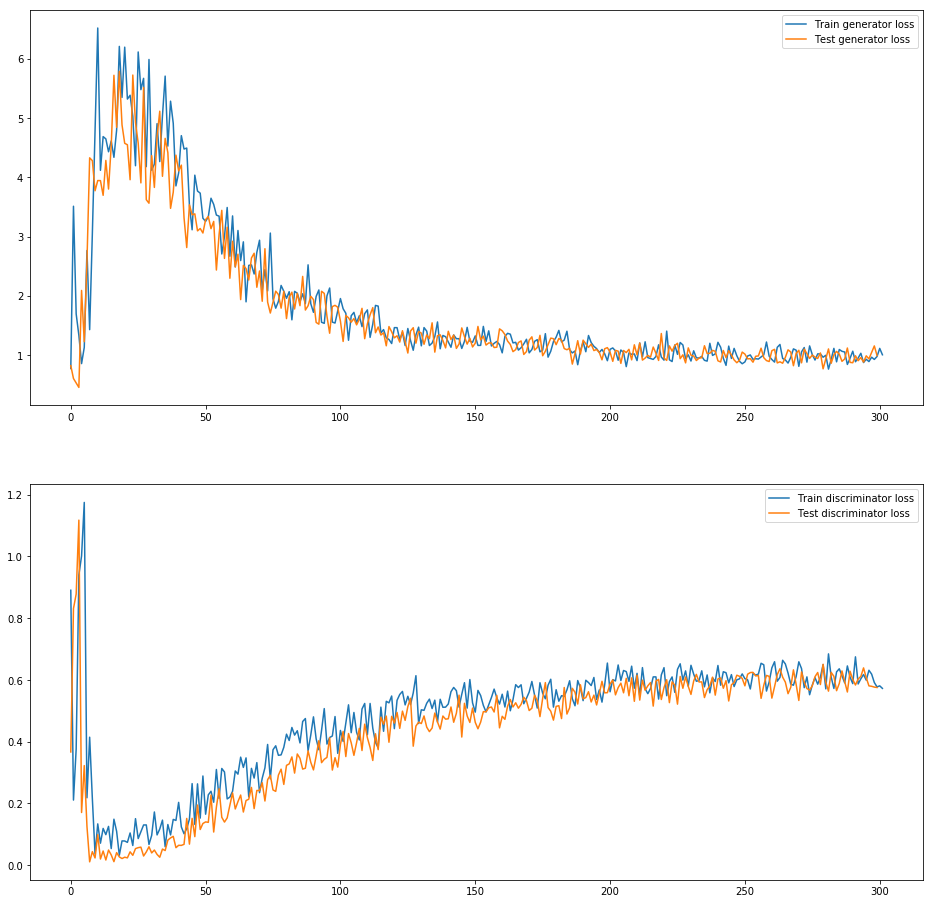

In [41]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(train_log["G"], label="Train generator loss")
plt.plot(test_log["G"], label="Test generator loss")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_log["D"], label="Train discriminator loss")
plt.plot(test_log["D"], label="Test discriminator loss")
plt.legend()
plt.show()

Plots of generated images from fixed target and random z samples. Correct numbers, different writing style.

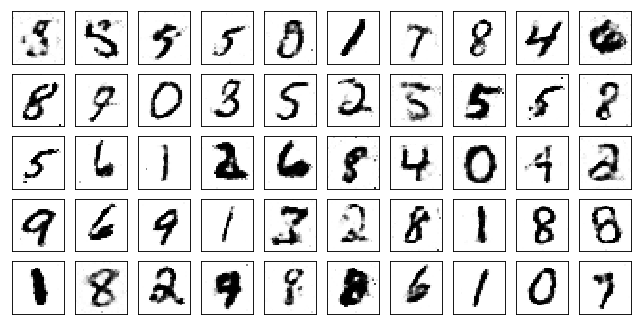

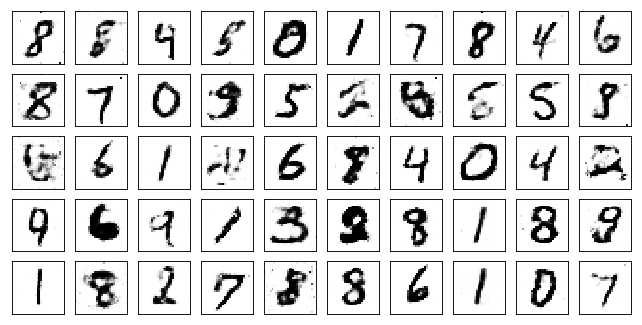

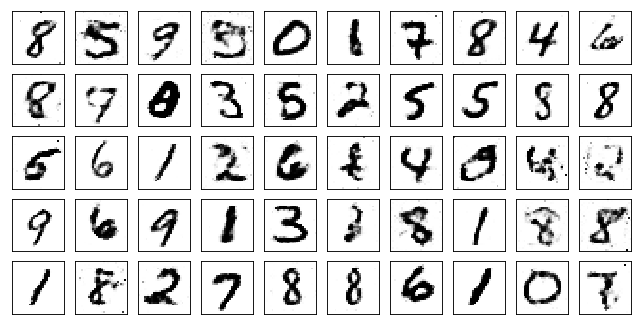

In [42]:
for i in range(3):
    fixed_gen = G(torch.randn((50, 100)).to(device), fixed_target.to(device)).cpu().data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True)